Attempt at Extracting More Than 1 Type of Feature

In [ ]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import zipfile
from scipy.io.wavfile import read
import subprocess
import re

In [ ]:
!pip install praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 89.4 MB/s eta 0:00:00


In [ ]:
!pip install opensmile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 19.1 MB/s eta 0:00:00


In [ ]:
import parselmouth
from parselmouth.praat import call
def extract_jitter(file_path):
    # Extract jitter using praat-parselmouth
    sound = parselmouth.Sound(file_path)
    point_process = call(sound, "To PointProcess (periodic, cc)", 75, 500)
    jitter_local = call(point_process, "Get jitter (local)", 0.0, 0.0, 0.0001, 0.02, 1.3)
    return jitter_local

In [ ]:
import opensmile
def extract_formants(file):
    # Initialize OpenSmile with GeMAPSv01b for formant frequencies
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.GeMAPSv01b,
        feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )

    # Process the audio file
    result_df = smile.process_file(file)

    # Select the three center formant frequencies
    centerformantfreqs = ['F1frequency_sma3nz', 'F2frequency_sma3nz', 'F3frequency_sma3nz']
    formant_df = result_df[centerformantfreqs]

    # Calculate mean formant frequencies
    formant_features = formant_df.mean().values

    return formant_features

**Dataset 1**
All 3 datasets combined

In [ ]:
def create_audio_dataset_with_derivatives(zip_file_path, extract_to):
    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    data = []
    jitter_features = []
    formant_features_list = []
    labels = []
    file_paths = []

    folder_title = re.sub(r"^/content/|.zip$", "", zip_file_path)
    # Iterate through subdirectories
    for label, subdir in enumerate([f'{folder_title}/Healthy Controls', f"{folder_title}/Parkinson's Disease"]):
        path = os.path.join(extract_to, subdir, '*.wav')
        print(path)
        for file in glob.glob(path):
            # Load audio file
            audio, sr = librosa.load(file, sr=None)

            #Extract jitter features
            jitter_feature = extract_jitter(file)
            jitter_features.append(jitter_feature)

            # Extract static MFCCs (13 coefficients)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

            # Compute first derivatives (Deltas)
            deltas = librosa.feature.delta(mfccs)

            # Compute second derivatives (Delta-Deltas)
            delta_deltas = librosa.feature.delta(mfccs, order=2)

            # Aggregate all features into a single vector (39-dimensional)
            mfcc_features = np.concatenate((np.mean(mfccs, axis=1),
                                            np.mean(deltas, axis=1),
                                            np.mean(delta_deltas, axis=1)))

            # Extract formant features
            formant_features = extract_formants(file)
            formant_features_list.append(formant_features)

            # Store data
            data.append(mfcc_features)
            labels.append(label)
            file_paths.append(file)

    # Create DataFrame with expanded features
    feature_columns = [f'MFCC_{i+1}' for i in range(13)] + \
                      [f'Delta_{i+1}' for i in range(13)] + \
                      [f'DeltaDelta_{i+1}' for i in range(13)]

    formant_columns = ['F1_frequency', 'F2_frequency', 'F3_frequency']

    df = pd.DataFrame(data, columns=feature_columns)
    df['jitter'] = pd.DataFrame(jitter_features)
    df[formant_columns] = pd.DataFrame(formant_features_list, columns=formant_columns)
    df['file_path'] = file_paths
    df['label'] = labels

    return df

# Usage example
zip_file_path = '/content/BME 499 FULL Dataset.zip'  # Your specific zip file name
extract_to = '/content/'  # Folder to extract the contents

# Create dataset with derivatives
dataset_with_derivatives = create_audio_dataset_with_derivatives(zip_file_path, extract_to)

# Save dataset to CSV (optional)
dataset_with_derivatives.to_csv('audio_dataset_with_derivatives.csv', index=False)

print(dataset_with_derivatives.head())


/content/BME 499 FULL Dataset/Healthy Controls/*.wav
/content/BME 499 FULL Dataset/Parkinson's Disease/*.wav
       MFCC_1      MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0 -341.388885  257.437103  58.596649 -38.874390 -31.998816 -21.740025   
1   15.402553   84.640030 -71.639496  -4.541304  -0.795856  -3.632197   
2 -399.535858  123.537025 -12.124429 -25.659477 -45.786701 -11.915327   
3 -343.246918  264.176636  51.769676 -37.127125 -24.749491 -22.592192   
4 -529.805298  101.130547  -4.303074 -32.868404 -24.428778 -10.536924   

      MFCC_7     MFCC_8     MFCC_9    MFCC_10  ...  DeltaDelta_10  \
0 -25.813129  -9.656718   9.120413   0.273829  ...      -0.000699   
1  -5.106176  10.440372  -1.969539 -21.190645  ...      -0.057252   
2 -40.806286  21.345398 -36.786434 -16.638359  ...       0.029249   
3 -24.584332   1.449075  15.351713  -3.974210  ...       0.001624   
4 -21.563469 -27.601212 -21.396263  13.271516  ...       0.000258   

   DeltaDelta_11  DeltaDelta_12  Delt

In [ ]:
# Usage example
zip_file_path_2 = '/content/BME 499 Dataset 1.zip'  # Your specific zip file name

# Create dataset with derivatives
dataset_with_derivatives_2 = create_audio_dataset_with_derivatives(zip_file_path_2, extract_to)

# Save dataset to CSV (optional)
dataset_with_derivatives_2.to_csv('smaller_audio_dataset_with_derivatives.csv', index=False)

print(dataset_with_derivatives_2.head())

/content/BME 499 Dataset 1/Healthy Controls/*.wav
/content/BME 499 Dataset 1/Parkinson's Disease/*.wav
       MFCC_1      MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0 -341.388885  257.437103  58.596649 -38.874390 -31.998816 -21.740025   
1 -343.246918  264.176636  51.769676 -37.127125 -24.749491 -22.592192   
2 -397.664825  168.880127  45.923992 -21.918591 -25.704374 -19.153343   
3 -347.658508  157.186630  17.453817 -50.019882 -48.594818 -37.889137   
4 -330.371521  233.938644  56.971779 -25.558395 -13.670223  -4.313496   

      MFCC_7     MFCC_8     MFCC_9    MFCC_10  ...  DeltaDelta_10  \
0 -25.813129  -9.656718   9.120413   0.273829  ...  -6.986067e-04   
1 -24.584332   1.449075  15.351713  -3.974210  ...   1.623639e-03   
2 -14.811393   0.233421   9.053962  -4.605341  ...   1.316269e-09   
3 -18.354782  11.912542  14.567437 -12.159837  ...  -9.319670e-05   
4 -13.455420  -4.980317   6.102508  -7.281969  ...  -6.668307e-04   

   DeltaDelta_11  DeltaDelta_12  DeltaDelta

##CORRELATION OF FEATURES

3 Combined Datasets (LARGE)

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features and labels
X_large = dataset_with_derivatives.drop(['file_path', 'label'], axis=1)
y_large = dataset_with_derivatives['label']

1 Dataset (SMALL)

In [ ]:
# Separate features and labels
X_small = dataset_with_derivatives_2.drop(['file_path', 'label'], axis=1)
y_small = dataset_with_derivatives_2['label']

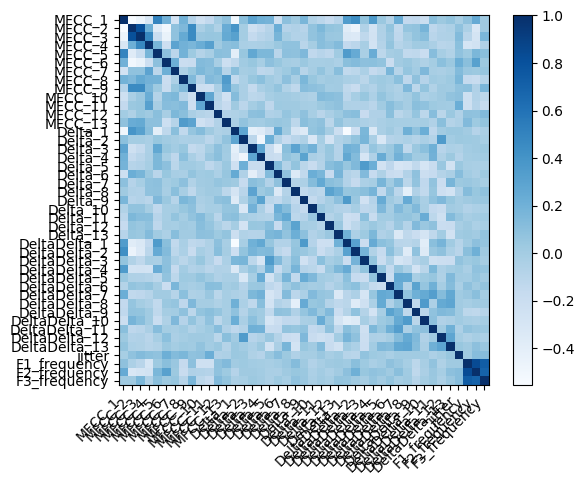

In [ ]:
import matplotlib.pyplot as plt
matrix = X_large.corr()

# plotting correlation matrix
plt.imshow(matrix, cmap='Blues')

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()

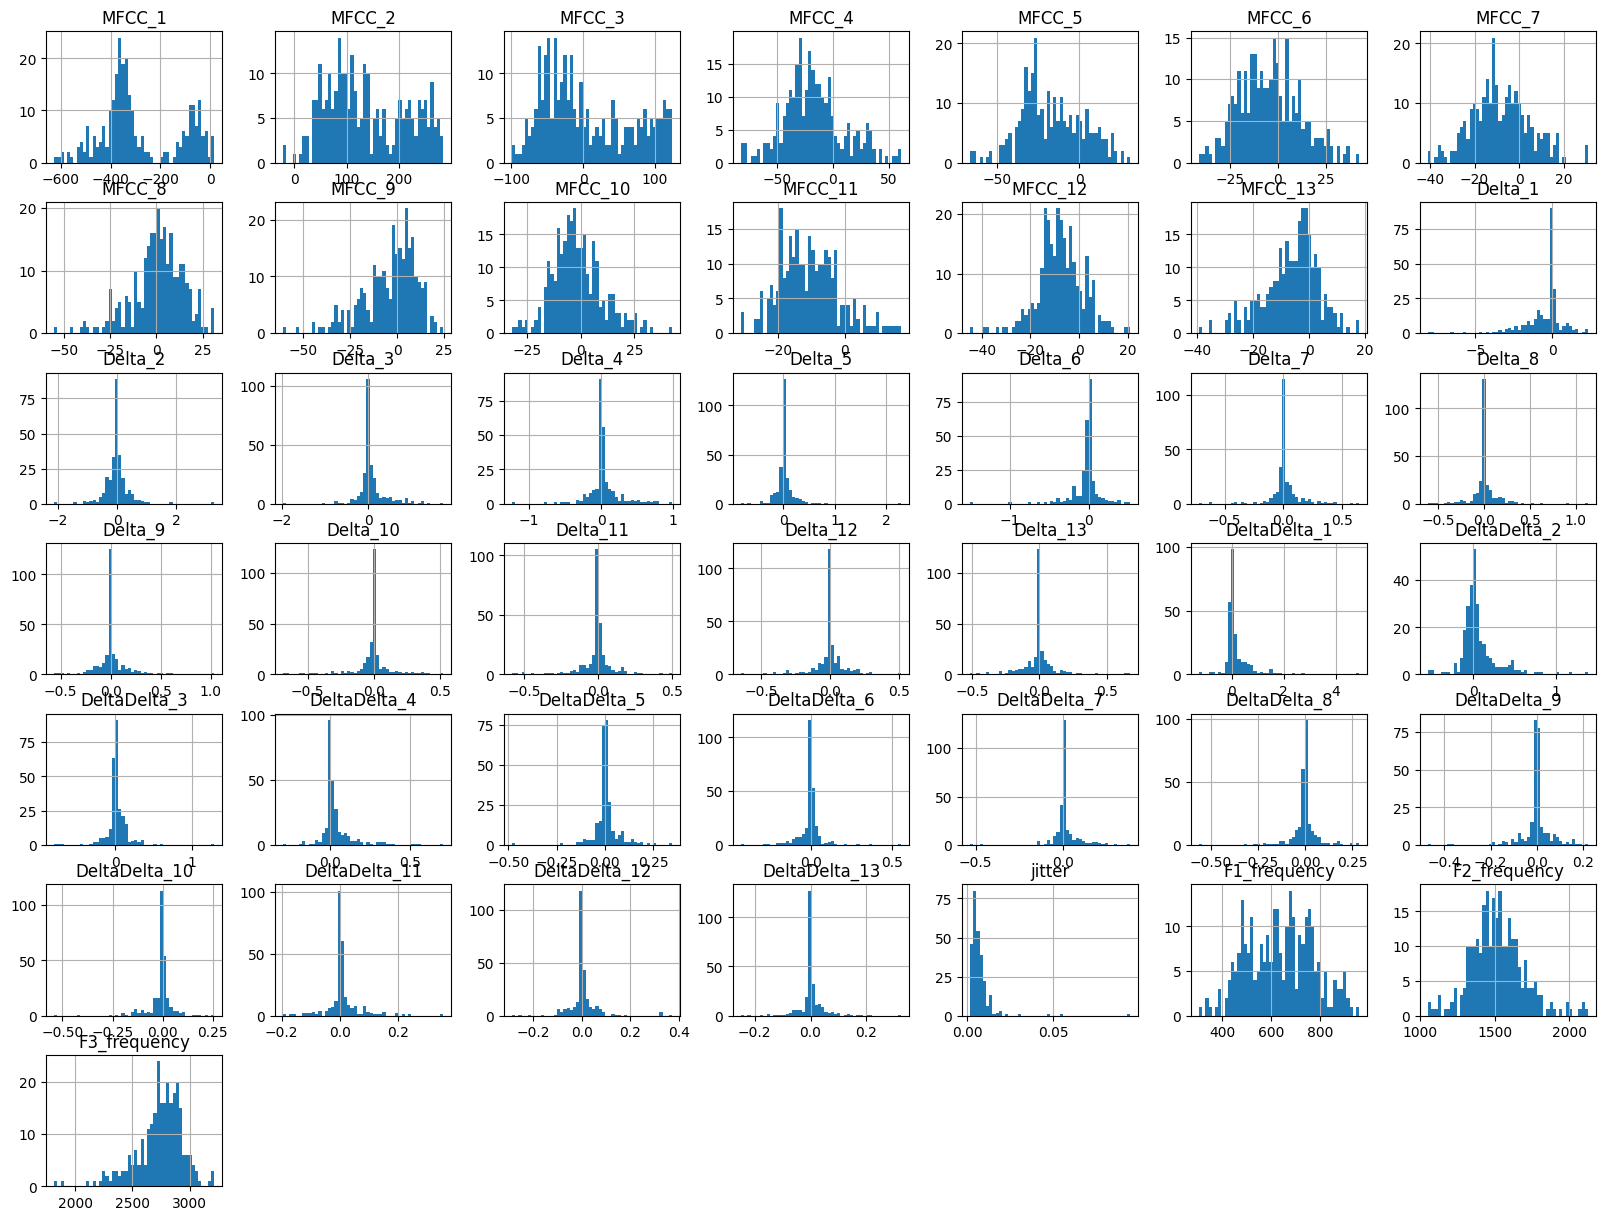

In [ ]:
X_large.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
X_large['log_jitter'] = np.log(X_large['jitter'])
X_small['log_jitter'] = np.log(X_small['jitter'])

In [ ]:
X_large_UPDATED = X_large.drop(columns=["jitter"])
X_small_UPDATED = X_small.drop(columns=["jitter"])

In [ ]:
corr_matrix = X_small_UPDATED.corr(method='pearson')
corr_matrix['MFCC_1'].sort_values(ascending=False)

,MFCC_1
MFCC_1,1.000000
MFCC_2,0.390461
F1_frequency,0.218468
DeltaDelta_5,0.218145
DeltaDelta_4,0.216794
DeltaDelta_11,0.166059
Delta_10,0.150706
Delta_9,0.102069
MFCC_12,0.094911
Delta_4,0.091652


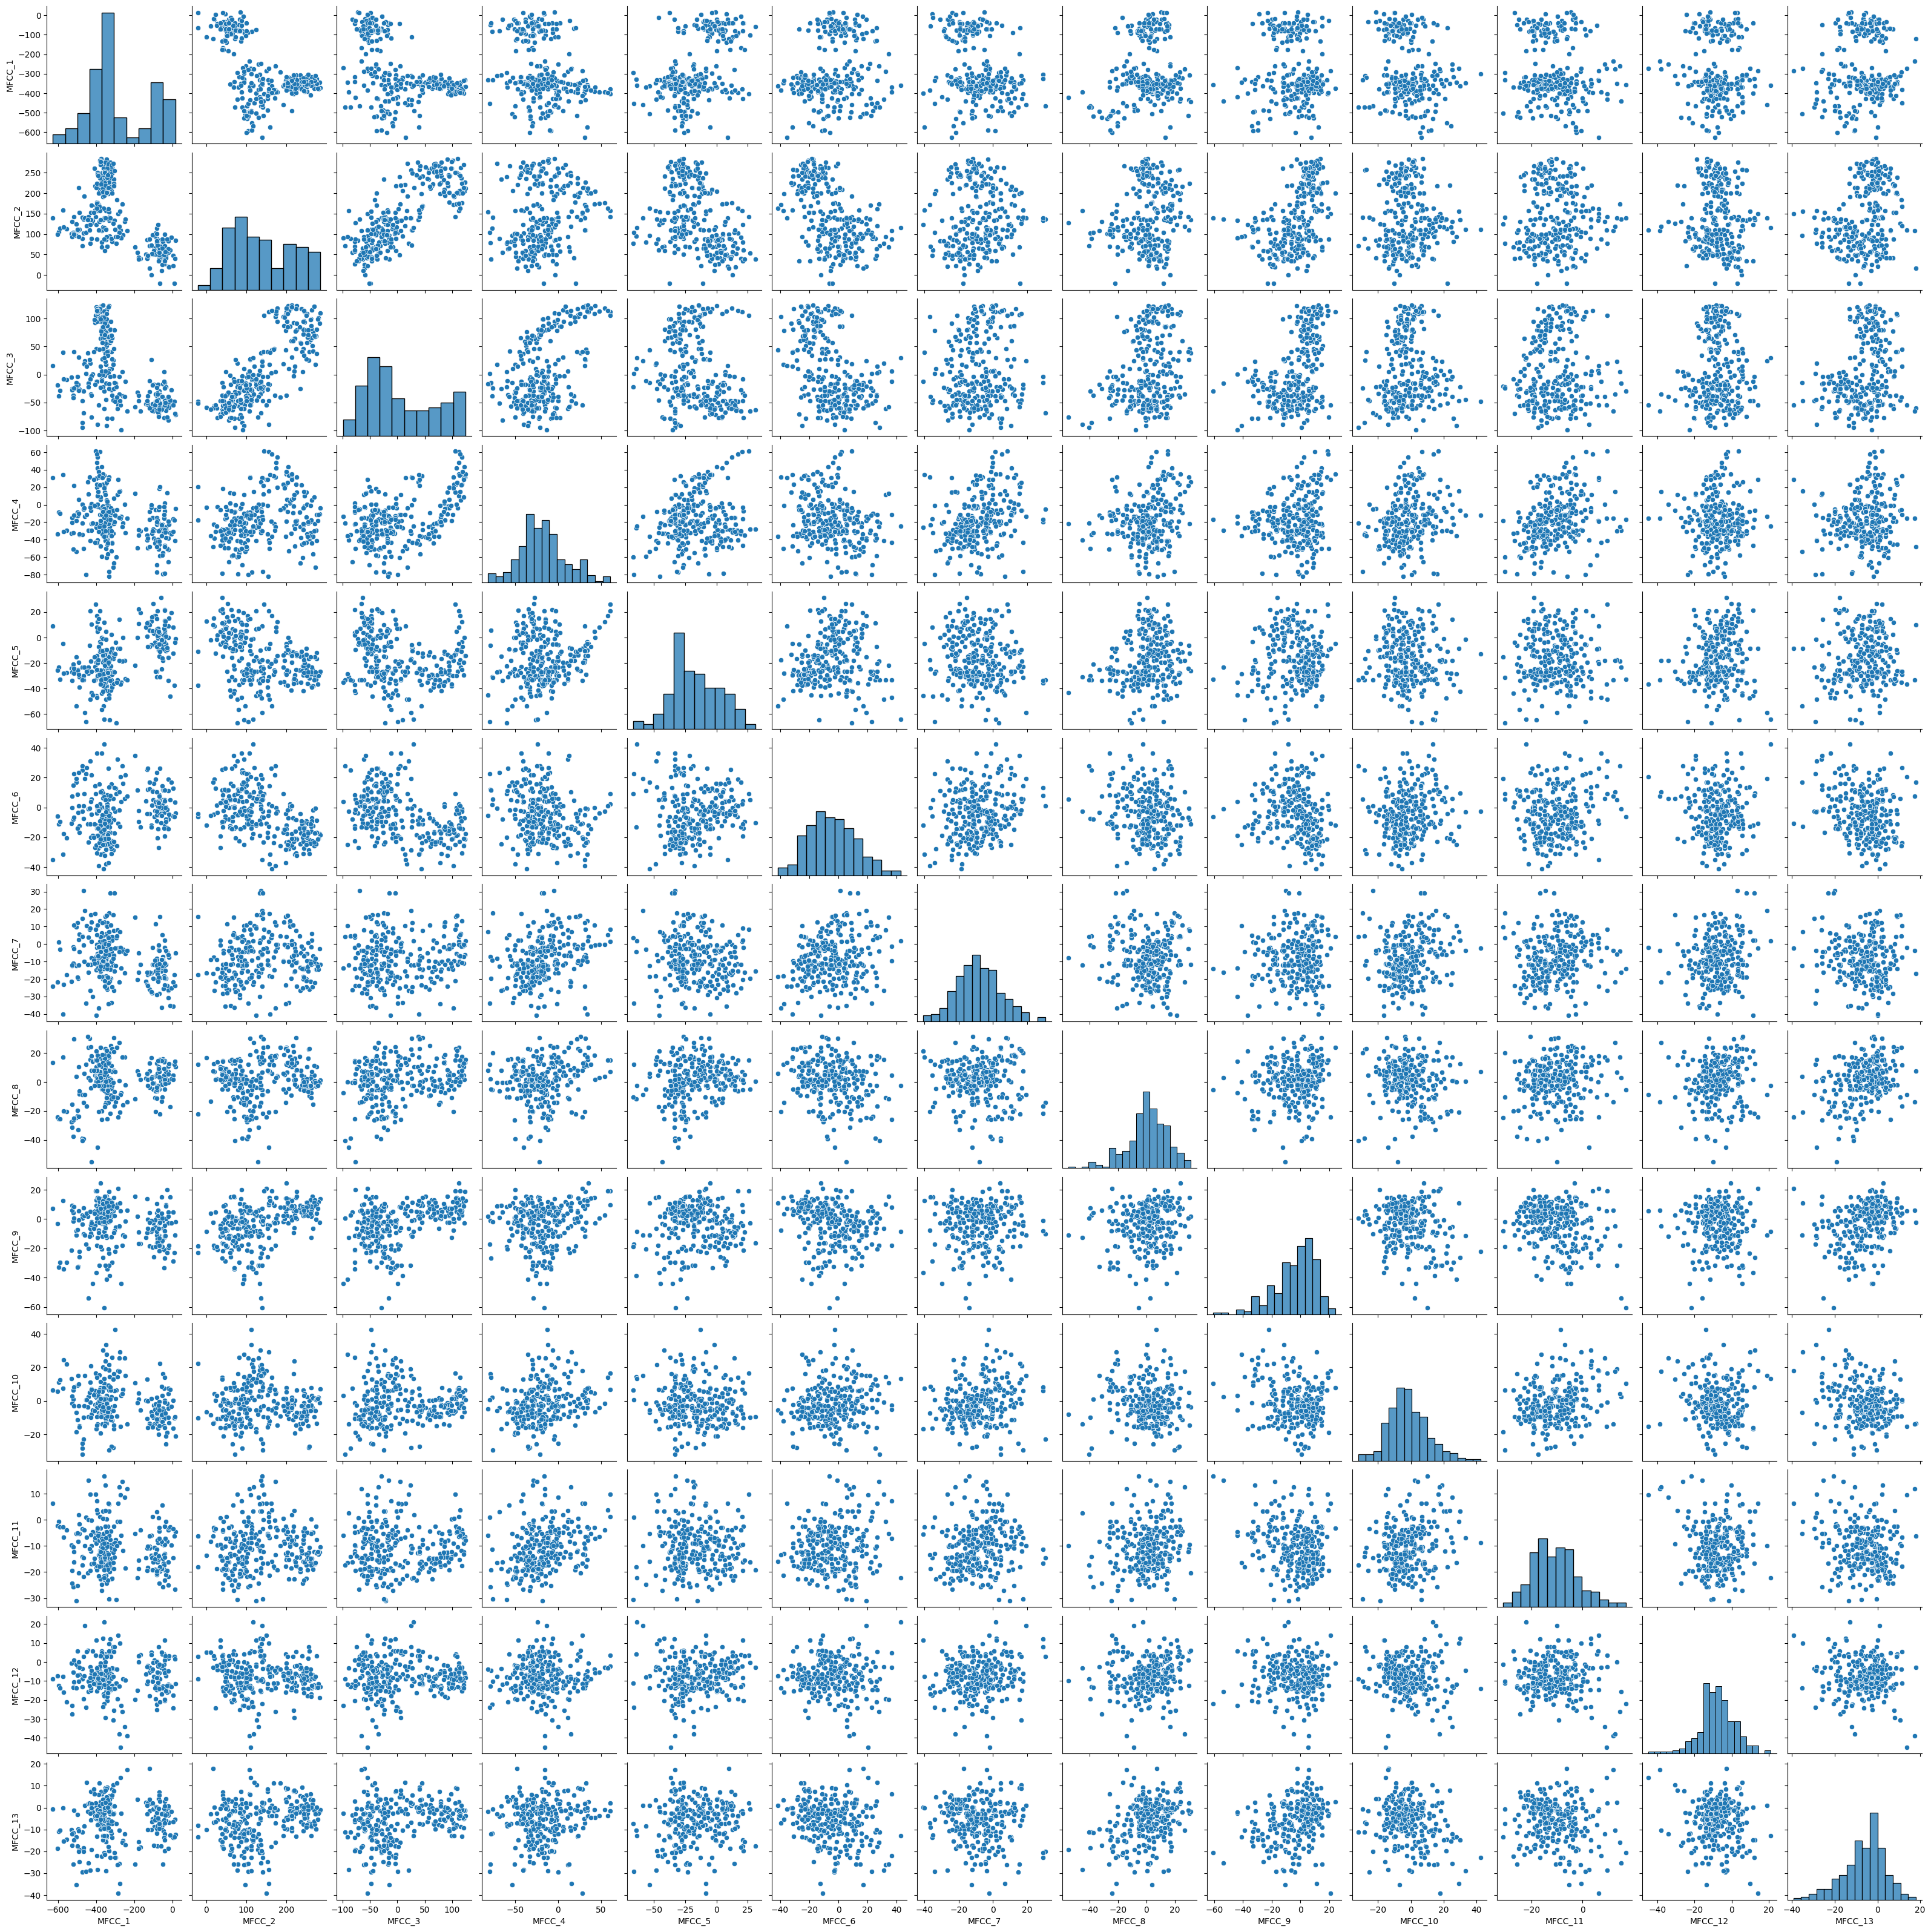

In [ ]:
import seaborn as sns

MFCC_columns = ['MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7',
       'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13']

first_derivatives = ['Delta_1', 'Delta_2', 'Delta_3', 'Delta_4', 'Delta_5', 'Delta_6',
       'Delta_7', 'Delta_8', 'Delta_9', 'Delta_10', 'Delta_11', 'Delta_12',
       'Delta_13']
second_derivatives = ['DeltaDelta_1', 'DeltaDelta_2', 'DeltaDelta_3',
       'DeltaDelta_4', 'DeltaDelta_5', 'DeltaDelta_6', 'DeltaDelta_7',
       'DeltaDelta_8', 'DeltaDelta_9', 'DeltaDelta_10', 'DeltaDelta_11',
       'DeltaDelta_12', 'DeltaDelta_13']
sns.pairplot(data=X_large_UPDATED.loc[:, MFCC_columns])

## SPLIT INTO TARGET AND FEATURES

3 Combined Datasets (LARGE)

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [ ]:
# Split the data into training, validation, and testing sets
X_train_large, X_temp_large, y_train_large, y_temp_large = train_test_split(X_large_UPDATED, y_large, test_size=0.3, random_state=42)
X_val_large, X_test_large, y_val_large, y_test_large = train_test_split(X_temp_large, y_temp_large, test_size=0.5, random_state=42)

In [ ]:
regular_train_df_large = pd.concat([X_train_large, y_train_large], axis=1)

1 Single Dataset

In [ ]:
# Split the data into training, validation, and testing sets
X_train_small, X_temp_small, y_train_small, y_temp_small = train_test_split(X_small_UPDATED, y_small, test_size=0.4, random_state=42)
X_val_small, X_test_small, y_val_small, y_test_small = train_test_split(X_temp_small, y_temp_small, test_size=0.5, random_state=42)

In [ ]:
regular_train_df_small = pd.concat([X_train_small, y_train_small], axis=1)

##SMOTE - Data Augmentation

3 Combined Datasets

In [ ]:
# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_large_smote, y_train_large_smote = smote.fit_resample(X_train_large, y_train_large)

# Create a new DataFrame with the augmented training data
columns = X_large_UPDATED.columns.tolist()
smote_train_df_large = pd.DataFrame(X_train_large_smote, columns=columns)
smote_train_df_large['label'] = y_train_large_smote

# Print the class distribution before and after SMOTE for the training set
print("Original training set class distribution:")
print(y_train_large.value_counts())
print("\nTraining set class distribution after SMOTE:")
print(y_train_large_smote.value_counts())

# Save the augmented training dataset to a new CSV file
smote_train_df_large.to_csv('augmented_train_dataset.csv', index=False)

print("\nAugmented training dataset shape:", smote_train_df_large.shape)
print("Augmented training dataset sample:")
print(smote_train_df_large.head())

# Keep the validation and test sets unchanged
val_df_large = pd.concat([X_val_large, y_val_large], axis=1)
test_df_large = pd.concat([X_test_large, y_test_large], axis=1)

print("\nValidation set shape:", val_df_large.shape)
print("Test set shape:", test_df_large.shape)

# Optionally, save validation and test sets
val_df_large.to_csv('validation_dataset.csv', index=False)
test_df_large.to_csv('test_dataset.csv', index=False)

Original training set class distribution:
label
1    104
0     85
Name: count, dtype: int64

Training set class distribution after SMOTE:
label
1    104
0    104
Name: count, dtype: int64

Augmented training dataset shape: (208, 44)
Augmented training dataset sample:
       MFCC_1      MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0 -460.561615  192.479675  19.002321  -3.586380 -23.520763   9.102368   
1 -395.151367  177.379105  94.203636  19.620300 -14.529490 -14.147047   
2 -336.383728  162.143112   2.209346 -18.999197 -20.594608  26.412365   
3 -353.916504   59.402607  -1.952004 -23.425993 -41.528084   5.716044   
4 -356.766144  139.091599 -29.317514 -16.580587 -33.006268  -6.232956   

      MFCC_7     MFCC_8     MFCC_9    MFCC_10  ...  DeltaDelta_9  \
0 -10.084951   5.855055   2.262914  -3.150377  ...     -0.008261   
1  -1.856447   4.168053  -2.384775 -14.676723  ...      0.000121   
2   3.500175  17.784883 -20.333805   9.404129  ...      0.019251   
3   1.277854 -17.1492

1 Combined Dataset

In [ ]:
X_train_small_smote, y_train_small_smote = smote.fit_resample(X_train_small, y_train_small)

# Create a new DataFrame with the augmented training data
columns = X_small_UPDATED.columns.tolist()
smote_train_df_small = pd.DataFrame(X_train_small_smote, columns=columns)
smote_train_df_small['label'] = y_train_small_smote

# Print the class distribution before and after SMOTE for the training set
print("Original training set class distribution:")
print(y_train_small.value_counts())
print("\nTraining set class distribution after SMOTE:")
print(y_train_small_smote.value_counts())

# Save the augmented training dataset to a new CSV file
smote_train_df_small.to_csv('smaller_augmented_train_dataset.csv', index=False)

print("\nAugmented training dataset shape:", smote_train_df_small.shape)
print("Augmented training dataset sample:")
print(smote_train_df_small.head())

# Keep the validation and test sets unchanged
val_df_small = pd.concat([X_val_small, y_val_small], axis=1)
test_df_small = pd.concat([X_test_small, y_test_small], axis=1)

print("\nValidation set shape:", val_df_small.shape)
print("Test set shape:", test_df_small.shape)

# Optionally, save validation and test sets
val_df_small.to_csv('smaller_validation_dataset.csv', index=False)
test_df_small.to_csv('smaller_test_dataset.csv', index=False)

Original training set class distribution:
label
1    30
0    24
Name: count, dtype: int64

Training set class distribution after SMOTE:
label
0    30
1    30
Name: count, dtype: int64

Augmented training dataset shape: (60, 44)
Augmented training dataset sample:
       MFCC_1      MFCC_2      MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0 -328.142761  260.230072   62.262100 -31.827951 -28.956936 -24.240364   
1 -319.463837  206.362183   10.063540 -52.997955 -26.840940 -27.847303   
2 -378.808868  237.064682  116.753296  22.360306 -11.022946  -9.074265   
3 -306.328156  234.580414  -25.002186 -66.500061 -14.582946 -24.733250   
4 -362.073486  163.380234   43.310421 -36.518047 -53.517513 -41.321072   

      MFCC_7    MFCC_8     MFCC_9    MFCC_10  ...  DeltaDelta_9  \
0 -21.520786  2.295920  13.015831  -5.779244  ...      0.000025   
1 -33.537617 -4.817856  10.763916 -10.762983  ...     -0.001297   
2  -1.171334  4.503481   4.779124  -3.201594  ...     -0.027160   
3 -26.529770  8.070841  

##Spline Interpolation

In [ ]:
from scipy.interpolate import interp1d

def spline_interpolate(features, n_new_samples):
    x = np.arange(len(features))
    x_new = np.linspace(0, len(features) - 1, n_new_samples)
    f = interp1d(x, features, kind='cubic')
    return f(x_new)

In [ ]:
def augment_data_spline(X, y, augmentation_factor=2):
    X_augmented = []
    y_augmented = []

    for label in np.unique(y):
        X_class = X[y == label]
        n_samples = len(X_class)

        for i in range(n_samples):
            X_augmented.append(X_class.iloc[i].values)
            y_augmented.append(label)

            for _ in range(augmentation_factor - 1):
                augmented_sample = spline_interpolate(X_class.iloc[i].values, len(X_class.iloc[i]))
                X_augmented.append(augmented_sample)
                y_augmented.append(label)

    return np.array(X_augmented), np.array(y_augmented)


3 Combined Datasets

In [ ]:
# Apply spline interpolation augmentation only to the training data
X_train_large_spline, y_train_large_spline = augment_data_spline(X_train_large, y_train_large, augmentation_factor=2)

In [ ]:
# Create a new DataFrame with the augmented training data
#columns = dataset_with_derivatives.drop(['file_path', 'label'], axis=1).columns.tolist()
columns = X_large_UPDATED.columns.tolist()
spline_train_df_large = pd.DataFrame(X_train_large_spline, columns=columns)
spline_train_df_large['label'] = y_train_large_spline

In [ ]:
# Print the class distribution before and after augmentation for the training set
print("Original training set class distribution:")
print(pd.Series(y_train_large).value_counts())
print("\nTraining set class distribution after Spline interpolation:")
print(pd.Series(y_train_large_spline).value_counts())

Original training set class distribution:
label
1    104
0     85
Name: count, dtype: int64

Training set class distribution after Spline interpolation:
1    208
0    170
Name: count, dtype: int64


1 Dataset

In [ ]:
# Apply spline interpolation augmentation only to the training data
X_train_small_spline, y_train_small_spline = augment_data_spline(X_train_small, y_train_small, augmentation_factor=2)

In [ ]:
spline_train_df_small = pd.DataFrame(X_train_small_spline, columns=columns)
spline_train_df_small['label'] = y_train_small_spline

In [ ]:
# Print the class distribution before and after augmentation for the training set
print("Original training set class distribution:")
print(pd.Series(y_train_small).value_counts())
print("\nTraining set class distribution after Spline interpolation:")
print(pd.Series(y_train_small_spline).value_counts())

Original training set class distribution:
label
1    30
0    24
Name: count, dtype: int64

Training set class distribution after Spline interpolation:
1    60
0    48
Name: count, dtype: int64


ATTEMPT AT SOMETHING ELSE

In [ ]:
X_train_large_CONDENSED = X_train_large.loc[:, MFCC_columns]

In [ ]:
X_val_large_CONDENSED = X_val_large.loc[:, MFCC_columns]
X_test_large_CONDENSED = X_test_large.loc[:, MFCC_columns]

## DATA NORMALIZATION

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
print(X_train_large.values)
tfmr = MinMaxScaler()
print(tfmr.fit_transform(X_train_large.values))

[[-4.60561615e+02  1.92479675e+02  1.90023212e+01 ...  1.05163379e+03
   1.89793958e+03 -4.51908137e+00]
 [-3.95151367e+02  1.77379105e+02  9.42036362e+01 ...  1.51052686e+03
   2.97816260e+03 -5.43229564e+00]
 [-3.36383728e+02  1.62143112e+02  2.20934629e+00 ...  1.62939233e+03
   2.89934448e+03 -3.06200326e+00]
 ...
 [-3.78816254e+02  2.08213242e+02  1.17233688e+02 ...  1.36257678e+03
   2.72031030e+03 -4.63036912e+00]
 [-1.40079346e+02  4.98804703e+01 -5.25843925e+01 ...  1.45751733e+03
   2.71894434e+03 -5.77930919e+00]
 [-3.44601624e+02  2.61393127e+02  9.84661102e+01 ...  1.38820288e+03
   2.33960034e+03 -5.56384782e+00]]
[[0.2577957  0.70131987 0.5234427  ... 0.         0.05797412 0.47479526]
 [0.35979448 0.65171164 0.86981541 ... 0.42720074 0.83145888 0.25321673]
 [0.45143499 0.60165852 0.44609527 ... 0.53785706 0.77502182 0.82833467]
 ...
 [0.38526697 0.75300762 0.97589043 ... 0.28946847 0.64682588 0.44779286]
 [0.75754617 0.2328545  0.19371862 ... 0.37785219 0.64584779 0.1690

In [ ]:
type(tfmr.fit_transform(X_train_large))

numpy.ndarray

In [ ]:
tfmr_X_train_large = tfmr.fit_transform(X_train_large)
tfmr_X_train_small = tfmr.fit_transform(X_train_small)

In [ ]:
tfmr_X_train_large_smote = tfmr.fit_transform(X_train_large_smote)
tfmr_X_train_small_smote = tfmr.fit_transform(X_train_small_smote)

In [ ]:
tfmr_X_train_large_spline = tfmr.fit_transform(X_train_large_spline)
tfmr_X_train_small_spline = tfmr.fit_transform(X_train_small_spline)

In [ ]:
tfmr_X_val_large = tfmr.fit_transform(X_val_large)
tfmr_X_test_large = tfmr.fit_transform(X_test_large)

In [ ]:
tfmr_X_val_small = tfmr.fit_transform(X_val_small)
tfmr_X_test_small = tfmr.fit_transform(X_test_small)

Reducing features of sorts

In [ ]:
tfmr_X_train_large_CONDENSED = tfmr.fit_transform(X_train_large_CONDENSED)
tfmr_X_val_large_CONDENSED = tfmr.fit_transform(X_val_large_CONDENSED)
tfmr_X_test_large_CONDENSED = tfmr.fit_transform(X_test_large_CONDENSED)

##TRAINING MODEL

Support Vector Machines

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
!pip install hyperopt

In [ ]:
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
roc_auc_score, roc_curve, confusion_matrix, f1_score
import numpy as np
from scipy import stats

# Define the objective function for SVM
def objective_svm(params):
    model = SVC(
        C=params['C'],
        kernel=params['kernel'],
        gamma='scale' if params['kernel'] == 'rbf' else 'auto'  # Gamma only applies to 'rbf'
    )

    # 10-fold CV on combined training data
    cv_scores = cross_val_score(
        model,
        np.vstack((tfmr_X_train_large_spline, tfmr_X_val_large)),
        np.concatenate((y_train_large_spline, y_val_large)),
        cv=10,
        scoring='accuracy'
    )

    return {'loss': -np.mean(cv_scores), 'status': STATUS_OK}

# Define the search space for SVM
space_svm = {
    'C': hp.loguniform('C', np.log(0.01), np.log(100)),  # Log scale for regularization parameter
    'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])  # Kernel types
}

# Initialize lists to store results
train_accuracies = []
val_accuracies = []
test_accuracies = []
precisions = []
recalls = []
specificities = []
f1_scores = []
roc_aucs = []

# Perform the process 5 times
for i in range(5):
    # Track trials for SVM
    trials_svm = Trials()

    # Run the optimization for SVM
    best_params_svm = fmin(
        fn=objective_svm,
        space=space_svm,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials_svm
    )

    # Convert categorical values back
    best_params_svm['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid'][best_params_svm['kernel']]

    # Train SVM with best parameters
    svm_best = SVC(
        C=best_params_svm['C'],
        kernel=best_params_svm['kernel'],
        gamma='scale' if best_params_svm['kernel'] == 'rbf' else 'auto'
    )

    svm_best.fit(tfmr_X_train_large_spline, y_train_large_spline)

    # Compute accuracies
    train_acc_svm = accuracy_score(y_train_large_spline, svm_best.predict(tfmr_X_train_large_spline))
    val_acc_svm = accuracy_score(y_val_large, svm_best.predict(tfmr_X_val_large))
    test_acc_svm = accuracy_score(y_test_small, svm_best.predict(tfmr_X_test_small))

    # Store results
    train_accuracies.append(train_acc_svm)
    val_accuracies.append(val_acc_svm)
    test_accuracies.append(test_acc_svm)

        # Compute predictions for the test set
    y_test_pred = svm_best.predict(tfmr_X_test_small)

    # Compute probabilities for AUC calculation (if applicable)
    y_test_probs = svm_best.decision_function(tfmr_X_test_small)  # Use decision_function for SVM

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test_small, y_test_pred)

    # Extract values from confusion matrix
    TN, FP, FN, TP = conf_matrix.ravel()

    # Metrics calculations
    precision = precision_score(y_test_small, y_test_pred)
    recall = recall_score(y_test_small, y_test_pred)  # Recall is equivalent to sensitivity
    specificity = TN / (TN + FP)  # Specificity calculation
    f1 = f1_score(y_test_small, y_test_pred)

    # AUC for ROC Curve
    roc_auc = roc_auc_score(y_test_small, y_test_probs)

    # Store additional metrics
    precisions.append(precision)
    recalls.append(recall)
    specificities.append(specificity)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)

    # Plot ROC Curve for each run
    fpr, tpr, thresholds = roc_curve(y_test_small, y_test_probs)

100%|██████████| 100/100 [00:10<00:00,  9.64trial/s, best loss: -0.7828106852497096]


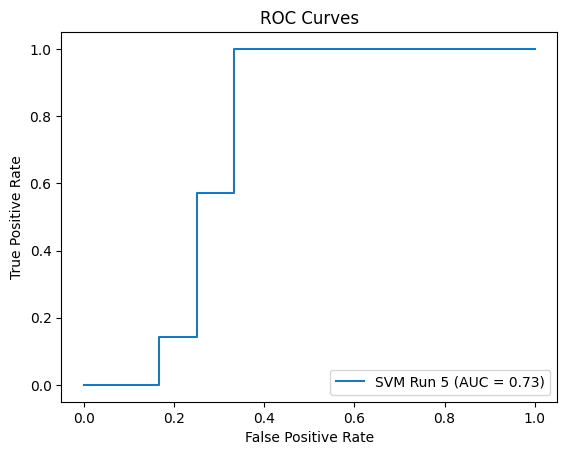

Mean Training Accuracy: 0.9693 ± 0.0040
Mean Validation Accuracy: 0.4976 ± 0.0119
Mean Test Accuracy: 0.4526 ± 0.0258
Mean Precision: 0.4026 ± 0.0112
Mean Recall (Sensitivity): 1.0000 ± 0.0000
Mean Specificity: 0.1333 ± 0.0408
Mean F1 Score: 0.5740 ± 0.0114
Mean ROC AUC: 0.7000 ± 0.0243
T-statistic: 74.95454313471657, p-value: 1.1184320484349548e-12
Reject the null hypothesis: Training and validation accuracies are significantly different.


In [ ]:
# Show all ROC curves
plt.plot(fpr, tpr, label=f"SVM Run {i+1} (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="best")
plt.show()

# Calculate mean and standard deviation of accuracies and other metrics
mean_train_acc = np.mean(train_accuracies)
std_train_acc = np.std(train_accuracies)
mean_val_acc = np.mean(val_accuracies)
std_val_acc = np.std(val_accuracies)
mean_test_acc = np.mean(test_accuracies)
std_test_acc = np.std(test_accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_specificity = np.mean(specificities)
std_specificity = np.std(specificities)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
mean_roc_auc = np.mean(roc_aucs)
std_roc_auc = np.std(roc_aucs)

# Print results
print(f"Mean Training Accuracy: {mean_train_acc:.4f} ± {std_train_acc:.4f}")
print(f"Mean Validation Accuracy: {mean_val_acc:.4f} ± {std_val_acc:.4f}")
print(f"Mean Test Accuracy: {mean_test_acc:.4f} ± {std_test_acc:.4f}")

print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall (Sensitivity): {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean Specificity: {mean_specificity:.4f} ± {std_specificity:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Mean ROC AUC: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")

# For statistical significance, you might compare these results against another model or baseline.
# Here, we'll just demonstrate a simple t-test comparing training and validation accuracies.
# Note: This is a simplistic example and might not be statistically valid without proper context.
t_stat, p_val = stats.ttest_ind(train_accuracies, val_accuracies)
print(f"T-statistic: {t_stat}, p-value: {p_val}")
if p_val < 0.05:
    print("Reject the null hypothesis: Training and validation accuracies are significantly different.")
else:
    print("Fail to reject the null hypothesis: Training and validation accuracies are not significantly different.")

In [ ]:
print(train_accuracies)
print(val_accuracies)
print(test_accuracies)
print(precisions)
print(recalls)
print(specificities)
print(f1_scores)
print(roc_aucs)

[0.9682539682539683, 0.9735449735449735, 0.9682539682539683, 0.9629629629629629, 0.9735449735449735]
[0.5121951219512195, 0.4878048780487805, 0.4878048780487805, 0.5121951219512195, 0.4878048780487805]
[0.47368421052631576, 0.42105263157894735, 0.47368421052631576, 0.47368421052631576, 0.42105263157894735]
[0.4117647058823529, 0.3888888888888889, 0.4117647058823529, 0.4117647058823529, 0.3888888888888889]
[1.0, 1.0, 1.0, 1.0, 1.0]
[np.float64(0.16666666666666666), np.float64(0.08333333333333333), np.float64(0.16666666666666666), np.float64(0.16666666666666666), np.float64(0.08333333333333333)]
[0.5833333333333334, 0.56, 0.5833333333333334, 0.5833333333333334, 0.56]
[np.float64(0.6785714285714285), np.float64(0.7261904761904762), np.float64(0.7023809523809523), np.float64(0.6666666666666666), np.float64(0.7261904761904762)]


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

100%|██████████| 100/100 [04:32<00:00,  2.73s/trial, best loss: -0.7071428571428571]


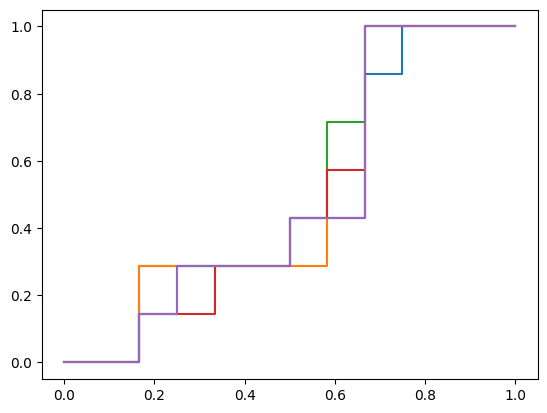

In [ ]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, f1_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
# Define the objective function
def objective(params):
    model = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        bootstrap=params['bootstrap'],
        random_state=42
    )

    # 10-fold CV on combined training data
    cv_scores = cross_val_score(
        model,
        np.vstack((tfmr_X_train_small, tfmr_X_val_small)),
        np.concatenate((y_train_small, y_val_small)),
        cv=10,
        scoring='accuracy'
    )

    return {'loss': -np.mean(cv_scores), 'status': STATUS_OK}

# Define the search space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 10),  # Integer step of 10
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

# Initialize lists to store results
train_accuracies = []
val_accuracies = []
test_accuracies = []
precisions = []
recalls = []
specificities = []
f1_scores = []
roc_aucs = []
pr_aucs = []

# Perform the process 5 times
for i in range(5):
    # Track trials for Random Forest
    trials = Trials()

    # Run the optimization
    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,  # Tree-structured Parzen Estimator
        max_evals=100,  # Number of iterations
        trials=trials
    )

    # Convert hyperparameters to appropriate types
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['min_samples_split'] = int(best_params['min_samples_split'])
    best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
    best_params['bootstrap'] = [True, False][best_params['bootstrap']]

    # Train Random Forest with best parameters
    rf_best = RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        bootstrap=best_params['bootstrap'],
        random_state=42
    )

    rf_best.fit(tfmr_X_train_small, y_train_small)

    # Compute accuracies
    train_acc_rf = accuracy_score(y_train_small, rf_best.predict(tfmr_X_train_small))
    val_acc_rf = accuracy_score(y_val_small, rf_best.predict(tfmr_X_val_small))
    test_acc_rf = accuracy_score(y_test_small, rf_best.predict(tfmr_X_test_small))

    # Store accuracy results
    train_accuracies.append(train_acc_rf)
    val_accuracies.append(val_acc_rf)
    test_accuracies.append(test_acc_rf)

    # Compute predictions for the test set
    y_test_pred = rf_best.predict(tfmr_X_test_small)

    # Compute probabilities for AUC calculation
    y_test_probs = rf_best.predict_proba(tfmr_X_test_small)[:, 1]  # Use predict_proba for Random Forest

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test_small, y_test_pred)

    # Extract values from confusion matrix
    TN, FP, FN, TP = conf_matrix.ravel()

    # Metrics calculations
    precision = precision_score(y_test_small, y_test_pred)
    recall = recall_score(y_test_small, y_test_pred)  # Recall is equivalent to sensitivity
    specificity = TN / (TN + FP)  # Specificity calculation
    f1 = f1_score(y_test_small, y_test_pred)

    # AUC for ROC Curve
    roc_auc = roc_auc_score(y_test_small, y_test_probs)

    # Precision-Recall Curve
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_test_small, y_test_probs)
    pr_auc = auc(recall_vals, precision_vals)

    # Store additional metrics
    precisions.append(precision)
    recalls.append(recall)
    specificities.append(specificity)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)
    pr_aucs.append(pr_auc)

    # Plot ROC Curve for each run
    fpr, tpr, thresholds = roc_curve(y_test_small, y_test_probs)
    plt.plot(fpr, tpr, label=f"Random Forest Run {i+1} (AUC = {roc_auc:.2f})")

<ipython-input-105-add6929de269>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


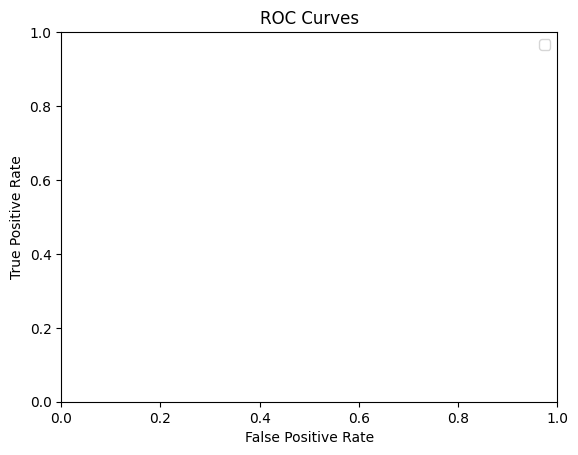

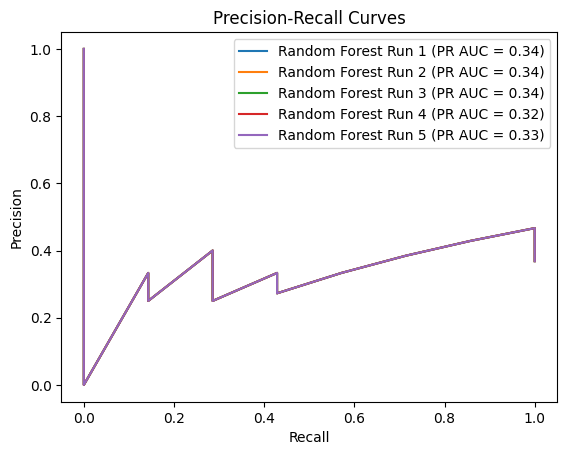

Mean Training Accuracy: 0.9593 ± 0.0444
Mean Validation Accuracy: 0.8444 ± 0.0222
Mean Test Accuracy: 0.4211 ± 0.0471
Mean Precision: 0.3145 ± 0.0413
Mean Recall (Sensitivity): 0.4857 ± 0.0700
Mean Specificity: 0.3833 ± 0.0408
Mean F1 Score: 0.3817 ± 0.0517
Mean ROC AUC: 0.4929 ± 0.0095
Mean Precision-Recall AUC: 0.3329 ± 0.0055
T-statistic: 4.62120715349957, p-value: 0.0017075093078250223
Reject the null hypothesis: Training and validation accuracies are significantly different.


In [ ]:
# Show all ROC curves
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="best")
plt.show()

# Show all Precision-Recall curves
for i in range(5):
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_test_small, rf_best.predict_proba(tfmr_X_test_small)[:, 1])
    plt.plot(recall_vals, precision_vals, label=f"Random Forest Run {i+1} (PR AUC = {pr_aucs[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="best")
plt.show()

# Calculate mean and standard deviation of accuracies and other metrics
mean_train_acc = np.mean(train_accuracies)
std_train_acc = np.std(train_accuracies)
mean_val_acc = np.mean(val_accuracies)
std_val_acc = np.std(val_accuracies)
mean_test_acc = np.mean(test_accuracies)
std_test_acc = np.std(test_accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_specificity = np.mean(specificities)
std_specificity = np.std(specificities)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
mean_roc_auc = np.mean(roc_aucs)
std_roc_auc = np.std(roc_aucs)
mean_pr_auc = np.mean(pr_aucs)
std_pr_auc = np.std(pr_aucs)

# Print results
print(f"Mean Training Accuracy: {mean_train_acc:.4f} ± {std_train_acc:.4f}")
print(f"Mean Validation Accuracy: {mean_val_acc:.4f} ± {std_val_acc:.4f}")
print(f"Mean Test Accuracy: {mean_test_acc:.4f} ± {std_test_acc:.4f}")

print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall (Sensitivity): {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean Specificity: {mean_specificity:.4f} ± {std_specificity:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Mean ROC AUC: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")
print(f"Mean Precision-Recall AUC: {mean_pr_auc:.4f} ± {std_pr_auc:.4f}")

# For statistical significance, you might compare these results against another model or baseline.
# Here, we'll just demonstrate a simple t-test comparing training and validation accuracies.
# Note: This is a simplistic example and might not be statistically valid without proper context.
from scipy import stats
t_stat, p_val = stats.ttest_ind(train_accuracies, val_accuracies)
print(f"T-statistic: {t_stat}, p-value: {p_val}")
if p_val < 0.05:
    print("Reject the null hypothesis: Training and validation accuracies are significantly different.")
else:
    print("Fail to reject the null hypothesis: Training and validation accuracies are not significantly different.")

In [ ]:
print(train_accuracies)
print(val_accuracies)
print(test_accuracies)
print(precisions)
print(recalls)
print(specificities)
print(f1_scores)
print(roc_aucs)

[0.9814814814814815, 0.8703703703703703, 0.9814814814814815, 0.9814814814814815, 0.9814814814814815]
[0.8888888888888888, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334]
[0.3684210526315789, 0.3684210526315789, 0.47368421052631576, 0.47368421052631576, 0.42105263157894735]
[0.2727272727272727, 0.2727272727272727, 0.36363636363636365, 0.36363636363636365, 0.3]
[0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.42857142857142855]
[np.float64(0.3333333333333333), np.float64(0.3333333333333333), np.float64(0.4166666666666667), np.float64(0.4166666666666667), np.float64(0.4166666666666667)]
[0.3333333333333333, 0.3333333333333333, 0.4444444444444444, 0.4444444444444444, 0.35294117647058826]
[np.float64(0.4880952380952381), np.float64(0.48809523809523814), np.float64(0.5119047619047619), np.float64(0.4880952380952381), np.float64(0.48809523809523814)]


K-Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt

# Define the objective function for KNN
def objective_knn(params):
    model = KNeighborsClassifier(
        n_neighbors=int(params['n_neighbors']),
        weights=params['weights'],
        metric=params['metric']
    )

    # 10-fold CV on combined training data
    cv_scores = cross_val_score(
        model,
        np.vstack((tfmr_X_train_large_spline, tfmr_X_val_large)),
        np.concatenate((y_train_large_spline, y_val_large)),
        cv=10,
        scoring='accuracy'
    )

    return {'loss': -np.mean(cv_scores), 'status': STATUS_OK}

# Define the search space for KNN
space_knn = {
    'n_neighbors': hp.quniform('n_neighbors', 1, 50, 1),  # K value (1 to 50)
    'weights': hp.choice('weights', ['uniform', 'distance']),  # Weighting scheme
    'metric': hp.choice('metric', ['euclidean', 'manhattan', 'minkowski'])  # Distance metric
}

# Initialize lists to store results
train_accuracies = []
val_accuracies = []
test_accuracies = []
precisions = []
recalls = []
specificities = []
f1_scores = []
roc_aucs = []

100%|██████████| 100/100 [00:03<00:00, 28.13trial/s, best loss: -0.7729965156794425]


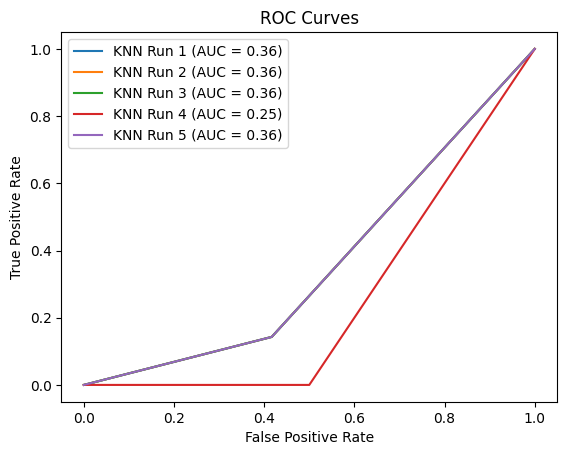

In [ ]:
# Perform the process 5 times
for i in range(5):
    # Track trials for KNN
    trials_knn = Trials()

    # Run the optimization for KNN
    best_params_knn = fmin(
        fn=objective_knn,
        space=space_knn,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials_knn
    )

    # Convert categorical values back
    best_params_knn['weights'] = ['uniform', 'distance'][best_params_knn['weights']]
    best_params_knn['metric'] = ['euclidean', 'manhattan', 'minkowski'][best_params_knn['metric']]
    best_params_knn['n_neighbors'] = int(best_params_knn['n_neighbors'])

    # Train KNN with best parameters
    knn_best = KNeighborsClassifier(
        n_neighbors=best_params_knn['n_neighbors'],
        weights=best_params_knn['weights'],
        metric=best_params_knn['metric']
    )

    knn_best.fit(tfmr_X_train_large_spline, y_train_large_spline)

    # Compute accuracies
    train_acc_knn = accuracy_score(y_train_large_spline, knn_best.predict(tfmr_X_train_large_spline))
    val_acc_knn = accuracy_score(y_val_large, knn_best.predict(tfmr_X_val_large))  # If you have a validation set
    test_acc_knn = accuracy_score(y_test_small, knn_best.predict(tfmr_X_test_small))

    # Store accuracy results
    train_accuracies.append(train_acc_knn)
    val_accuracies.append(val_acc_knn)
    test_accuracies.append(test_acc_knn)

    # Compute predictions for the test set
    y_test_pred = knn_best.predict(tfmr_X_test_small)

    # Since KNN does not provide probabilities, we can't directly compute AUC.
    # However, we can use a workaround for binary classification by binarizing labels.
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test_small)
    y_test_pred_binarized = lb.transform(y_test_pred)

    # For binary classification, we can use the binarized labels to compute AUC.
    # However, this approach assumes binary classification and may not work for multi-class.
    if len(np.unique(y_test_small)) == 2:
        y_test_probs = np.array([1 - i for i in y_test_pred_binarized])  # Pseudo-probabilities for the negative class
        roc_auc = roc_auc_score(y_test_binarized[:, 0], y_test_probs[:, 0])  # Compute AUC for binary case
    else:
        print("AUC calculation not supported for multi-class KNN without probability outputs.")
        roc_auc = None

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test_small, y_test_pred)

    # Extract values from confusion matrix
    if len(conf_matrix) == 2:  # Binary case
        TN, FP, FN, TP = conf_matrix.ravel()
    else:  # Multi-class case
        TN = np.sum(np.diag(conf_matrix)) - np.diag(conf_matrix)[0]  # Approximation for multi-class
        FP = np.sum(conf_matrix, axis=0) - np.diag(conf_matrix)
        FN = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)
        TP = np.diag(conf_matrix)

    # Metrics calculations
    precision = precision_score(y_test_small, y_test_pred, average='weighted')  # Use weighted average for multi-class
    recall = recall_score(y_test_small, y_test_pred, average='weighted')  # Recall is equivalent to sensitivity
    specificity = TN / (TN + FP) if len(conf_matrix) == 2 else np.mean([conf_matrix[i, i] / (conf_matrix[i, i] + np.sum(conf_matrix[:, i]) - conf_matrix[i, i]) for i in range(len(conf_matrix))])  # Specificity calculation for binary and multi-class
    f1 = f1_score(y_test_small, y_test_pred, average='weighted')

    # Store additional metrics
    precisions.append(precision)
    recalls.append(recall)
    specificities.append(specificity)
    f1_scores.append(f1)
    if roc_auc is not None:
        roc_aucs.append(roc_auc)
    else:
        roc_aucs.append(np.nan)  # Store NaN if AUC is not applicable

    # Plot ROC Curve (for binary classification)
    if len(np.unique(y_test_small)) == 2:
        fpr, tpr, thresholds = roc_curve(y_test_binarized[:, 0], y_test_probs[:, 0])
        plt.plot(fpr, tpr, label=f"KNN Run {i+1} (AUC = {roc_auc:.2f})")

# Show all ROC curves
if len(np.unique(y_test_small)) == 2:
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="best")
    plt.show()


In [ ]:
# Calculate mean and standard deviation of accuracies and other metrics
mean_train_acc = np.mean(train_accuracies)
std_train_acc = np.std(train_accuracies)
mean_val_acc = np.mean(val_accuracies)
std_val_acc = np.std(val_accuracies)
mean_test_acc = np.mean(test_accuracies)
std_test_acc = np.std(test_accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_specificity = np.mean(specificities)
std_specificity = np.std(specificities)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
mean_roc_auc = np.nanmean(roc_aucs)  # Use nanmean to ignore NaN values
std_roc_auc = np.nanstd(roc_aucs)  # Use nanstd to ignore NaN values

# Print results
print(f"Mean Training Accuracy: {mean_train_acc:.4f} ± {std_train_acc:.4f}")
print(f"Mean Validation Accuracy: {mean_val_acc:.4f} ± {std_val_acc:.4f}")
print(f"Mean Test Accuracy: {mean_test_acc:.4f} ± {std_test_acc:.4f}")

print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall (Sensitivity): {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean Specificity: {mean_specificity:.4f} ± {std_specificity:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
if not np.isnan(mean_roc_auc):
    print(f"Mean ROC AUC: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")

# For statistical significance, you might compare these results against another model or baseline.
# Here, we'll just demonstrate a simple t-test comparing training and validation accuracies.
# Note: This is a simplistic example and might not be statistically valid without proper context.
from scipy import stats
t_stat, p_val = stats.ttest_ind(train_accuracies, val_accuracies)
print(f"T-statistic: {t_stat}, p-value: {p_val}")
if p_val < 0.05:
    print("Reject the null hypothesis: Training and validation accuracies are significantly different.")
else:
    print("Fail to reject the null hypothesis: Training and validation accuracies are not significantly different.")

Mean Training Accuracy: 1.0000 ± 0.0000
Mean Validation Accuracy: 0.5463 ± 0.0119
Mean Test Accuracy: 0.6000 ± 0.0421
Mean Precision: 0.7231 ± 0.0534
Mean Recall (Sensitivity): 0.6000 ± 0.0421
Mean Specificity: 0.4333 ± 0.0333
Mean F1 Score: 0.5933 ± 0.0428
Mean ROC AUC: 0.3405 ± 0.0452
T-statistic: 75.93418202627844, p-value: 1.0082117070751365e-12
Reject the null hypothesis: Training and validation accuracies are significantly different.


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
print(train_accuracies)
print(val_accuracies)
print(test_accuracies)
print(precisions)
print(recalls)
print(specificities)
print(f1_scores)
print(roc_aucs)

[1.0, 1.0, 1.0, 1.0, 1.0]
[0.5609756097560976, 0.5609756097560976, 0.5365853658536586, 0.5365853658536586, 0.5365853658536586]
[0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.6842105263157895, 0.5789473684210527]
[0.6963562753036436, 0.6963562753036436, 0.6963562753036436, 0.8299595141700405, 0.6963562753036436]
[0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.6842105263157895, 0.5789473684210527]
[np.float64(0.4166666666666667), np.float64(0.4166666666666667), np.float64(0.4166666666666667), np.float64(0.5), np.float64(0.4166666666666667)]
[0.5719298245614035, 0.5719298245614035, 0.5719298245614035, 0.6789473684210525, 0.5719298245614035]
[np.float64(0.363095238095238), np.float64(0.363095238095238), np.float64(0.363095238095238), np.float64(0.25), np.float64(0.363095238095238)]
